# Stock Market Predictive Analysis
In this notebook we will visualize the data gathered from yahoo stock exchange from markets all over the world and building a model for a specific market to see if there is any merit to trying to predict the future with machine learning.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [17]:
df = pd.read_csv('indexProcessed.csv') # Create the dataframe from the csv
print(df.head()) # Check for easier reference to the parameters

  Index        Date         Open         High          Low        Close  \
0   HSI  1986-12-31  2568.300049  2568.300049  2568.300049  2568.300049   
1   HSI  1987-01-02  2540.100098  2540.100098  2540.100098  2540.100098   
2   HSI  1987-01-05  2552.399902  2552.399902  2552.399902  2552.399902   
3   HSI  1987-01-06  2583.899902  2583.899902  2583.899902  2583.899902   
4   HSI  1987-01-07  2607.100098  2607.100098  2607.100098  2607.100098   

     Adj Close  Volume    CloseUSD  
0  2568.300049     0.0  333.879006  
1  2540.100098     0.0  330.213013  
2  2552.399902     0.0  331.811987  
3  2583.899902     0.0  335.906987  
4  2607.100098     0.0  338.923013  


Check to make sure the data is clean and can be used

In [18]:
print(df.isnull().sum())
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)
df = df[df['Volume'] != 0] # Remove any input with a volume of 0 because it is not useful for what we are trying to do
print(df.head())

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
dtype: int64
     Index        Date         Open         High          Low        Close  \
3590   HSI  2001-07-09  12768.62012  12768.62012  12583.33008  12690.67969   
3591   HSI  2001-07-10  12701.13965  12731.96973  12634.99023  12713.90039   
3592   HSI  2001-07-11  12625.45020  12625.45020  12457.50977  12527.90039   
3593   HSI  2001-07-12  12533.38965  12693.29981  12533.38965  12660.20020   
3594   HSI  2001-07-13  12779.71973  12820.84961  12518.19043  12612.79004   

        Adj Close       Volume     CloseUSD  
3590  12690.67969  257038800.0  1649.788360  
3591  12713.90039  134407800.0  1652.807051  
3592  12527.90039  195057600.0  1628.627051  
3593  12660.20020  174767800.0  1645.826026  
3594  12612.79004  211230200.0  1639.662705  


no data is null, there is no clearning that was needed to be done from empty cells. 

In [19]:
df = df.sort_values(by='Date')

In [20]:
grouped = df.groupby('Index')

In [21]:
# Reformat date into something readable idk when I didn't do this things broke
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by=['Index', 'Date'])


# Visualize the data
Generally speaking the price of each market in USD goes up. Perhaps due to the value of USD being worth less over time because of inflation.

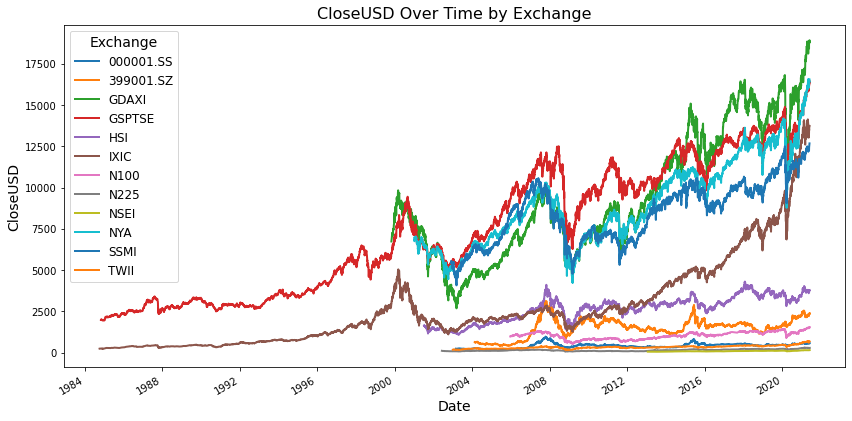

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Group the data by Stock exchange name
grouped = df.groupby('Index')

for name, group in grouped:
    plt.plot(group['Date'], group['CloseUSD'], label=name, linewidth=2)
    
plt.title('CloseUSD Over Time by Exchange', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('CloseUSD', fontsize=14)

plt.legend(title='Exchange', fontsize=12, title_fontsize=14)

plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

Graph of all the markets. some similar trends of spikes and declines are easy to observe from a glance. Some markets are too low relative to the global market and not rendered in a very readable way in this graph, so we will graph them on their own.

In [23]:
index_info_df = pd.read_csv('indexInfo.csv')
exchange_names = index_info_df.set_index('Index')['Exchange'].to_dict()

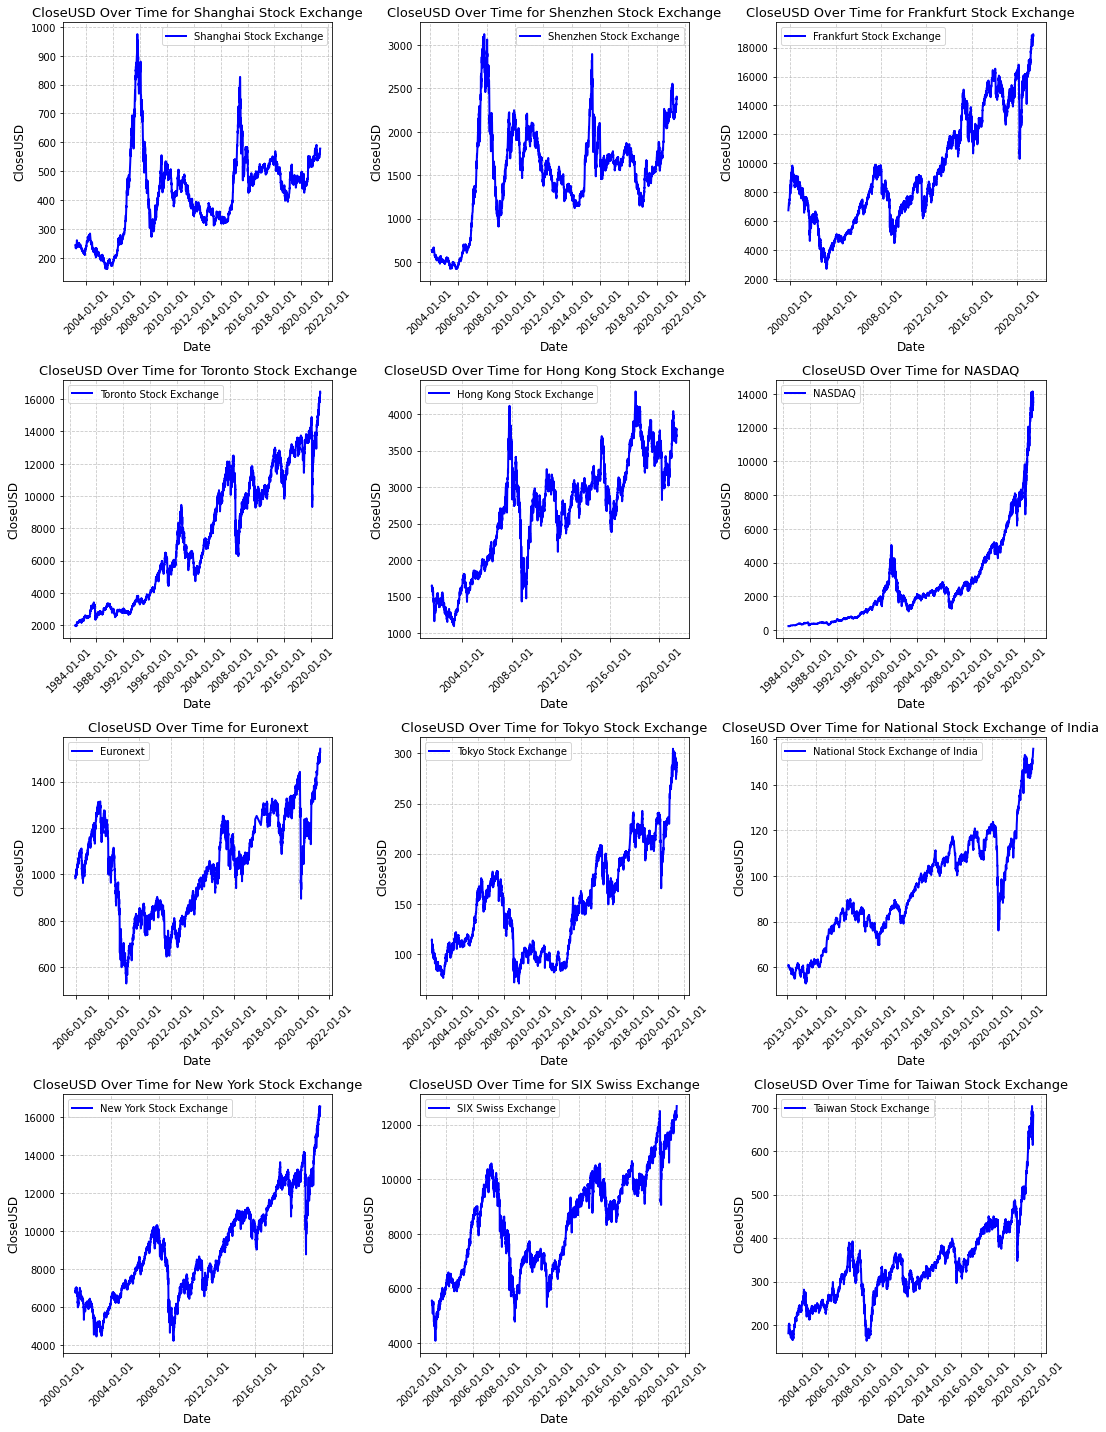

In [24]:
import math
unique_exchanges = df['Index'].unique()

num_exchanges = len(unique_exchanges)
num_rows = math.ceil(math.sqrt(num_exchanges))
num_cols = math.ceil(num_exchanges / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

axes = axes.flatten()

for i, exchange in enumerate(unique_exchanges):
    exchange_data = df[df['Index'] == exchange]
    exchange_name = exchange_names.get(exchange, exchange)
    axes[i].plot(exchange_data['Date'], exchange_data['CloseUSD'], label=exchange_name, linewidth=2, color='blue')
    axes[i].set_title(f'CloseUSD Over Time for {exchange_name}', fontsize=13)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('CloseUSD', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)
    
for j in range(i + 1, len(axes)): # Gets rid of the unused graphs as it tries to make a square
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### Little things that are easy to observe from the data without any analysis
Every market has some kind of dip, some bigger than others, around 2008 when the housing market crashed. this affected everyone all around the world because of the American market going wild.  
Additionally for the data that has it, in 2020 most markets also had a dip besides the 2 chinese exchanges but they all started to climb even after the start of the pandemic and did have a longterm dip like the financial crash of 2008.  
There are global trends that can be seen in stock market data. Should the model be able to come to any meaningful conclusions it might be able to predict global events. 

# Train a predictive model based on the data
To simplify the understanding and make real time testing easier lets look at just the NASDAQ or IXIC index to make a model and predict future stocks with. Since the data is 4 years old and we have had time pass as it tends to do we can use our model to see how accurate it is with predictions on the real stock market

In [25]:
NYA_data = df[df['Index'] == 'NYA']
NASDAQ_data = df[df['Index'] == 'IXIC']
NYA_data = NYA_data[['Date', 'Volume', 'CloseUSD']]
NASDAQ_data =NASDAQ_data[['Date', 'Volume', 'CloseUSD']]
print(NYA_data.head())

            Date        Volume     CloseUSD
17306 2001-01-03  1.880700e+09  6968.830078
17307 2001-01-04  2.169400e+09  6894.810059
17308 2001-01-05  1.430800e+09  6774.060059
17309 2001-01-08  1.115500e+09  6759.049805
17310 2001-01-09  1.191300e+09  6754.819824


In [26]:
NASDAQ_data['Year'] = NASDAQ_data['Date'].dt.year
NASDAQ_data['Month'] = NASDAQ_data['Date'].dt.month
NASDAQ_data['Day'] = NASDAQ_data['Date'].dt.day
NASDAQ_data['DayOfWeek'] = NASDAQ_data['Date'].dt.dayofweek # Monday=0, Sunday=6

NASDAQ_data['Close_Lag1'] = NASDAQ_data['CloseUSD'].shift(1)
NASDAQ_data['Volume_Lag1'] = NASDAQ_data['Volume'].shift(1)

NASDAQ_data = NASDAQ_data.dropna()

print(NASDAQ_data.head())

            Date      Volume    CloseUSD  Year  Month  Day  DayOfWeek  \
25897 1984-10-12  58860000.0  246.199997  1984     10   12          4   
25898 1984-10-15  61820000.0  247.699997  1984     10   15          0   
25899 1984-10-16  57440000.0  247.300003  1984     10   16          1   
25900 1984-10-17  64670000.0  247.100006  1984     10   17          2   
25901 1984-10-18  64730000.0  249.800003  1984     10   18          3   

       Close_Lag1  Volume_Lag1  
25897  244.699997   62860000.0  
25898  246.199997   58860000.0  
25899  247.699997   61820000.0  
25900  247.300003   57440000.0  
25901  247.100006   64670000.0  


In [27]:
X = NASDAQ_data[['Date', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'Close_Lag1', 'Volume_Lag1']]
y = NASDAQ_data['CloseUSD']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7385, 8) (1847, 8) (7385,) (1847,)


In [28]:
X_train_dates = X_train['Date']
X_test_dates = X_test['Date']

X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_results = pd.DataFrame({
    'Date': X_test_dates,
    'Actual': y_test,
    'Predicted': y_pred
})

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3223.872243329056
Mean Absolute Error: 28.485724121310202


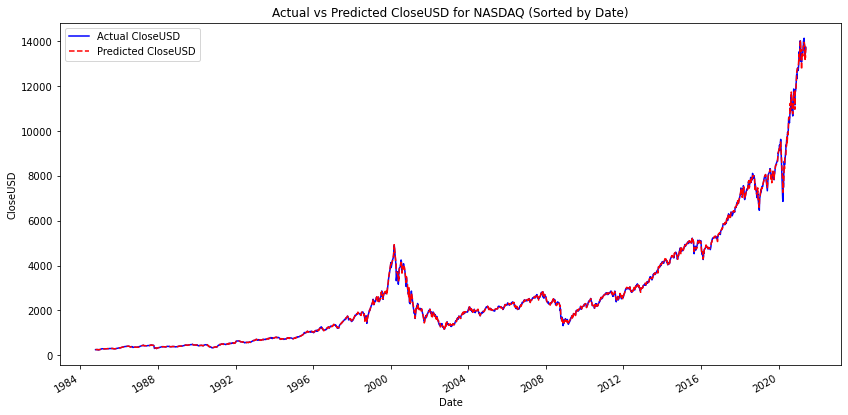

In [29]:
import matplotlib.pyplot as plt
# Sort needed as graph does not go by date and is entierly unreadable if not sorted
test_results = test_results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(test_results['Date'], test_results['Actual'], label='Actual CloseUSD', color='blue')
plt.plot(test_results['Date'], test_results['Predicted'], label='Predicted CloseUSD', color='red', linestyle = '--')
plt.title('Actual vs Predicted CloseUSD for NASDAQ (Sorted by Date)')
plt.xlabel('Date')
plt.ylabel('CloseUSD')
plt.legend()
plt.gcf().autofmt_xdate() 
plt.show()

        Date  CloseUSD_Lag1        Volume  Year  Month  Day  DayOfWeek  \
0 2021-05-29    13748.74023  4.435220e+09  2021      5   29          5   
1 2021-05-30    13748.74023  4.435220e+09  2021      5   30          6   
2 2021-05-31    13748.74023  4.435220e+09  2021      5   31          0   
3 2021-06-01    13748.74023  4.435220e+09  2021      6    1          1   
4 2021-06-02    13748.74023  4.435220e+09  2021      6    2          2   

    Volume_Lag1  
0  4.435220e+09  
1  4.435220e+09  
2  4.435220e+09  
3  4.435220e+09  
4  4.435220e+09  
         Date  Predicted_CloseUSD
0  2021-05-29          241.795002
1  2021-05-30          241.795002
2  2021-05-31          241.795002
3  2021-06-01          241.808002
4  2021-06-02          241.694002
5  2021-06-03          241.603001
6  2021-06-04          241.638002
7  2021-06-05          241.638002
8  2021-06-06          241.638002
9  2021-06-07          241.638002
10 2021-06-08          241.638002
11 2021-06-09          241.638002
12 20

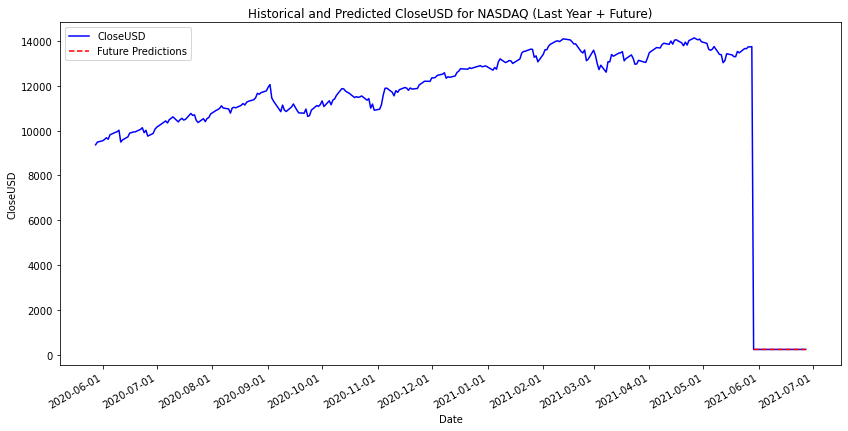

In [30]:

last_date = NASDAQ_data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

future_data = pd.DataFrame({'Date': future_dates})
historical_data = NASDAQ_data[['Date', 'CloseUSD']]

future_data['CloseUSD_Lag1'] = NASDAQ_data['CloseUSD'].iloc[-1]
future_data['Volume'] = NASDAQ_data['Volume'].iloc[-1]
future_data['Year'] = future_data['Date'].dt.year
future_data['Month'] = future_data['Date'].dt.month
future_data['Day'] = future_data['Date'].dt.day
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek  # Monday=0, Sunday=6
future_data['Volume_Lag1'] = NASDAQ_data['Volume'].iloc[-1]

print(future_data.head())
X_future = future_data.drop(columns=['Date'])

future_predictions = model.predict(X_future)

future_data['Predicted_CloseUSD'] = future_predictions

print(future_data[['Date', 'Predicted_CloseUSD']])

last_year_data = historical_data[historical_data['Date'] >= (historical_data['Date'].max() - pd.Timedelta(days=365))]

future_data = future_data[['Date', 'Predicted_CloseUSD']].rename(columns={'Predicted_CloseUSD': 'CloseUSD'})

combined_data = pd.concat([last_year_data, future_data])

plt.figure(figsize=(14, 7))
plt.plot(combined_data['Date'], combined_data['CloseUSD'], label='CloseUSD', color='blue')
plt.plot(future_data['Date'], future_data['CloseUSD'], label='Future Predictions', color='red', linestyle='--')
plt.title('Historical and Predicted CloseUSD for NASDAQ (Last Year + Future)')
plt.xlabel('Date')
plt.ylabel('CloseUSD')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.legend()

plt.show()

# What Happened?
### Overfit model
If you look at the closeUSD from the end of the data you can see its 13,748 but the predicted close is 241, or about 57 times lower than what the previous datapoint was. When the model is placed over known data it does a pretty good job fitting to the line that's drawn suggesting that when having to deal with guessing data the model has no clue what to go off of indicating that it is overfit, looking too hard into details that don't matter for its prediction.  
### Fundamental problem
Well if random forest classifier doesn't do a good job modeling the stock market does anything else have a shot?  
Not really. There is just too much going on with too much randomness in the whole world to predict the market at any level where one could make any money. The whole system is just way too complex with too many parameters especially a dataset that is just the large market, not even the individual companies these markets are based on.  
Being able to see the effects of COVID-19, even if brief, is interesting data, and would be a better question to ask with this kind of data is what, if anything, happened in these dips on the graph? Are there other, perhaps more subtle world market treds, that can be seen with statistical analysis and machine learning? Asking the question if we could predict the stock market is not productive because if we had a nice mathmatical way to figure this stuff out someone would be already doing it to great success. Our advice would be to flip a coin and buy on heads and sell on tails, that would be more accurate than this data. 